# Chapter 6 and 7 - Loading data, cleaning and preparation

This notebook is light on the various data loading described in Ch 6, because most of those formats described are all just loaded with various pandas `pd.read_...()` helpers that do all the heavy lifting.  Thats great if you have tabular data.  I am instead going to feed you with a netCDF4 file, which takes a little bit more work to load, but only a few lines.  Ping me if you get stuck.

Grab the data here:

https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz

I'm not sure if the various options for opening that file (described below) handle the compression, so you probably want to `gzip -d` that file.   This dataset has global temperatures, averaged monthly within 2x2 degree boxes over land (the grid points over the oceans are filled with NaN). The data spans from January 1880 through January 2019, though spatial coverage is sparse at the earlier dates and gets much better with time.

The imports below should cover the various ways to complete the notebook.  

##### Reference

GISTEMP Team, 2019: GISS Surface Temperature Analysis (GISTEMP v4). NASA Goddard Institute for Space Studies. Dataset accessed 2019-03-06 at https://data.giss.nasa.gov/gistemp/.

Hansen, J., R. Ruedy, M. Sato, and K. Lo, 2010: Global surface temperature change, Rev. Geophys., 48, RG4004, doi:10.1029/2010RG000345.

In [1]:
# You may not need all of these, but you shouldn't need more. YOLO
import pandas as pd
#import netCDF4 as nc4
import xarray as xr
import seaborn as sns
import numpy as np
sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
datafile_nc4 = '/Users/dgriffis/code/glg/python-data-analysis-crash-course/data/gistemp250_GHCNv4.nc'

### Working with a netCDF4 data file

There are a few ways to go about this, as in anything python related.  Pandas does not speak netCDF by default, but there are some easy ways to get this data into a dataframe.

1. Load the data with the netCDF4 package and build a dataframe with the variables you are interested in
2. Load the data with xarray.open_dataset and convert that to a dataframe with to_dataframe(). 

There is more in this file than we really need, so if you can get to this state, you win:

```
>>> print(df.columns)

Index(['lat', 'lon', 'time', 'tempanomaly'], dtype='object')
```

In [3]:
DS = xr.open_dataset(datafile_nc4)
#DS.values
#DS.var
#DS.dims
#Using DS.coords we can see it as a dict containing three of the of interest keys
#DS.coords
#DS.attrs
df = DS.to_dataframe()
#df = df[:100] 
df = pd.DataFrame(df.to_records())
df = df.drop(['time_bnds','nv'],axis=1)
print(df.columns)
#print(df)




Index(['lat', 'lon', 'time', 'tempanomaly'], dtype='object')


The lat and lon variables give global coverage every 2 degrees (only odd value of lat and lon) of temperature anomaly (the deviation from the climate average).  Produce a timeseries (data or plot) of the temperature anomaly near Boston, MA. (lat,lon = 43.0, -71.0)

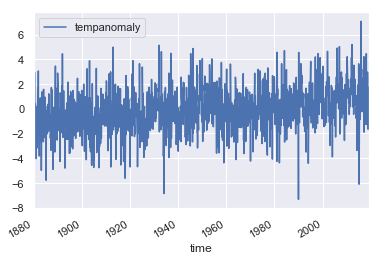

In [4]:
dataBoston = df.loc[(df['lat'] == 43.0) & (df['lon'] == -71.0)]
dataBoston.plot(x='time', y='tempanomaly');

Are there any NaN or missing values in this data?  

In [24]:
dataBoston.tempanomaly.isnull().values.any()

False

Now take a look at the same data at the location (lat,lon = 1.0, -87.0).  Does this data have missing values or NaN?  Are they appropriate? 

In [25]:
myData = df.loc[(df['lat'] == 1.0) & (df['lon'] == -87.0)]
myData.tempanomaly.isnull().values.any()

True

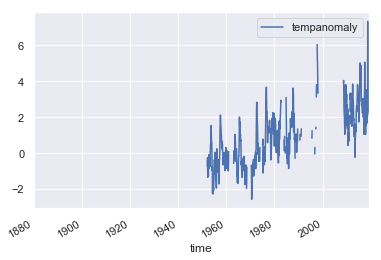

In [26]:
myData.plot(x='time', y='tempanomaly');

Now let's focus on a slice of this data in time.  Pick a date in 2018 and all the temperature anomalies and locations associated with that date.  This data is going to come out of pandas, most likely, looking like this:

```
           lat    lon  tempanomaly
1666     -89.0 -179.0         0.42
3335     -89.0 -179.0         0.42
5004     -89.0 -177.0         0.42
...
[32400 rows x 3 columns]
```

(your data will be different if you chose a different date)

Find the average of the warmest and coolest 10% of the data for the date you chose.

In [8]:
myTest = df.loc[df['time'] == '2018-09-15'].drop(['time'], axis=1)
coolest = myTest.loc[myTest.tempanomaly <= myTest.tempanomaly.quantile(0.1)]
coolest.describe()
print(coolest.tempanomaly.mean())

-3.2741008


In [9]:
warmest = myTest.loc[myTest.tempanomaly >= myTest.tempanomaly.quantile(0.9)]
warmest.describe()
print(warmest.tempanomaly.mean())

3.575602


#### BONUS!  (I solved this with stuff that turns out was in CH8, but I'm keeping it in)

The last question had data like this:

```
           lat    lon  tempanomaly
1666     -89.0 -179.0         0.42
3335     -89.0 -179.0         0.42
5004     -89.0 -177.0         0.42
...
[32400 rows x 3 columns]
```

I'm going give you some code to plot a heatmap, but first the data needs to be transformed to look like this:

```
lon    -179.0  -177.0  -175.0  -173.0  -171.0  -169.0  -167.0  -165.0  -163.0  \
lat                                                                             
 81.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 79.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 77.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 ...
[86 rows x 180 columns]
```

Go for it!

In [21]:
myTest = myTest.drop_duplicates()
table = myTest.pivot(index='lat',columns='lon',values='tempanomaly').sort_values('lat',axis=0,ascending=False)
print (table)

lon    -179.0  -177.0  -175.0  -173.0  -171.0  -169.0  -167.0  -165.0  -163.0  \
lat                                                                             
 89.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 87.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 85.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 83.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 81.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 79.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 77.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 75.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
 73.0    6.15    6.15    6.15    6.15    6.15     NaN     NaN     NaN     NaN   
 71.0    6.14    6.14    6.14    6.14    4.98    3.65    3.65    3.65    3.65   
 69.0    5.97    5.97    5.9

If your data looks like the 86x180 2-d example above, then go ahead and run this next cell.  You'll need to change the globaltemps, of course, to whatever your dataset is called.  If you chocse "2018-11-15" as your date, your output should look like this:

![weather](img/weather.png)


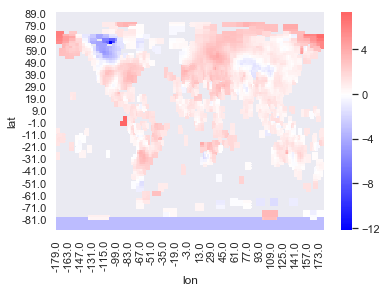

In [23]:
sns.heatmap(data=table, center=0, cmap="bwr");

This plot looks vaguely like a world map, because this dataset only has values for land. 

Congrats, you're done.  I was asked for warm weather, and I think this dataset delivers.